In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/labels-3/liver_50.nii
/kaggle/input/labels-3/liver_46.nii
/kaggle/input/labels-3/liver_90.nii
/kaggle/input/labels-3/liver_96.nii
/kaggle/input/labels-3/liver_121.nii
/kaggle/input/labels-3/liver_97.nii
/kaggle/input/labels-3/liver_55.nii
/kaggle/input/labels-3/liver_91.nii
/kaggle/input/labels-3/liver_38.nii
/kaggle/input/labels-3/liver_128.nii
/kaggle/input/labels-3/liver_83.nii
/kaggle/input/labels-3/liver_116.nii
/kaggle/input/labels-3/liver_51.nii
/kaggle/input/labels-3/liver_117.nii
/kaggle/input/labels-3/liver_104.nii
/kaggle/input/labels-3/liver_81.nii
/kaggle/input/labels-3/liver_67.nii
/kaggle/input/labels-3/liver_39.nii
/kaggle/input/labels-3/liver_118.nii
/kaggle/input/labels-3/liver_120.nii
/kaggle/input/labels-3/liver_107.nii
/kaggle/input/labels-3/liver_35.nii
/kaggle/input/labels-3/liver_43.nii
/kaggle/input/labels-3/liver_31.nii
/kaggle/input/labels-3/liver_59.nii
/kaggle/input/labels-3/liver_109.nii
/kaggle/input/labels-3/liver_40.nii
/kaggle/input/label

Importing libraries and Monai transformations

In [4]:
import os
from glob import glob
#import shutil
#from tqdm import tqdm
#import dicom2nifti
#import numpy as np
#import nibabel as nib
#!pip install monai
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

Data Preprocessing Pipeline

In [5]:
import os
import torch
import numpy as np
from glob import glob
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstD, Spacingd, Orientationd, 
    ScaleIntensityRanged, CropForegroundd, Resized, ToTensord, MapTransform
)
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import set_determinism

# Custom normalization transform
class NormalizeToOneRange(MapTransform):
    """
    A transform that normalizes the values of the image to the range [0, 1].
    """
    def __init__(self, keys):
        super().__init__(keys)
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            image_min = d[key].min()
            image_max = d[key].max()
            if image_max > image_min:
                d[key] = (d[key] - image_min) / (image_max - image_min)
            else:
                d[key] = np.zeros_like(d[key])  # Handle case where the range is 0
        return d

def prepare(images_dir, labels_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):
    """
    This function prepares and preprocesses the MRI and segmentation data.
    It includes basic transforms and normalization.
    """

    set_determinism(seed=0)

    # Get the paths for volumes and segmentation directly from the provided directories
    path_train_volumes = sorted(glob(os.path.join(images_dir, "*.nii")))
    path_train_segmentation = sorted(glob(os.path.join(labels_dir, "*.nii")))

    # Check if files were found
    if not path_train_volumes:
        raise ValueError(f"No image files found in {images_dir}")
    if not path_train_segmentation:
        raise ValueError(f"No label files found in {labels_dir}")

    # Create the train_files list
    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]

    # Define the transformation pipeline
    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            NormalizeToOneRange(keys=["vol"]),  # Add custom normalization to range [0, 1]
            ToTensord(keys=["vol", "seg"]),
        ]
    )

    # Load the dataset using CacheDataset or regular Dataset
    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=2)
        return train_loader
    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=2)
        return train_loader


In [ ]:
# Create a folder named 'unzipped_folder' (or any other name)
!mkdir images
# Unzip the file into the 'unzipped_folder' directory
!unzip "Archive 3.zip" -d images

In [6]:
label_dir='/kaggle/input/labels-1'
image_dir='/kaggle/input/image-1'
data_in = prepare(image_dir, label_dir, cache=True)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 11/11 [02:26<00:00, 13.36s/it]


 Convolutional neural network with residual connections and attention mechanisms

In [7]:
#working p2

import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        # Reduced number of filters in the convolution layer
        self.conv = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=1, padding=patch_size // 2)

    def forward(self, x):
        return self.conv(x)  # Keeps original spatial dimensions

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction_ratio=8):  # Reduced reduction ratio
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv3d(in_planes, in_planes // reduction_ratio, kernel_size=1, bias=False)
        self.fc2 = nn.Conv3d(in_planes // reduction_ratio, in_planes, kernel_size=1, bias=False)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=(2, 3, 4), keepdim=True)  # Global Average Pooling
        max_pool = torch.amax(x, dim=(2, 3, 4), keepdim=True)  # Global Max Pooling

        avg_out = self.fc2(F.relu(self.fc1(avg_pool)))
        max_out = self.fc2(F.relu(self.fc1(max_pool)))
        return torch.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3):  # Reduced kernel size
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv3d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool = torch.max(x, dim=1, keepdim=True).values
        concat = torch.cat([avg_pool, max_pool], dim=1)
        return x * torch.sigmoid(self.conv(concat))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        # Reduced number of filters in the convolution layer
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)

class ResidualBlockWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlockWithAttention, self).__init__()
        stride = 2 if downsample else 1
        self.conv1 = ConvBlock(in_channels, out_channels, stride=stride)
        self.conv2 = ConvBlock(out_channels, out_channels, stride=1)
        self.downsample = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride) if downsample else None

        # Attention layers
        self.channel_attn = ChannelAttention(out_channels)
        self.spatial_attn = SpatialAttention()

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)

        # Apply channel and spatial attention
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        
        if self.downsample is not None:
            residual = self.downsample(residual)
        
        return x + residual  # Residual connection

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        # Reduced number of filters in the transposed convolution layer
        self.upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels, out_channels)

    def forward(self, x):
        x = self.upsample(x)
        return self.conv(x)

class ConvNetWithAttention(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_classes):
        super(ConvNetWithAttention, self).__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, embed_dim)
        
        # Convolutional blocks with residual connections and attention mechanisms
        self.res_block1 = ResidualBlockWithAttention(embed_dim, embed_dim * 2, downsample=True)
        self.res_block2 = ResidualBlockWithAttention(embed_dim * 2, embed_dim * 2, downsample=True)  # Same number of filters
        self.res_block3 = ResidualBlockWithAttention(embed_dim * 2, embed_dim * 2, downsample=True)  # Same number of filters
        
        # Upsampling blocks to restore spatial dimensions
        self.up_block1 = UpsampleBlock(embed_dim * 2, embed_dim)
        self.up_block2 = UpsampleBlock(embed_dim, embed_dim)
        self.up_block3 = UpsampleBlock(embed_dim, embed_dim)

        # Final convolution to map to output classes
        self.final_conv = nn.Conv3d(embed_dim, num_classes, kernel_size=1)

    def forward(self, x):
        # Embedding patches from the input
        x = self.patch_embedding(x)  # Shape: [B, embed_dim, H', W', D']

        # Downsampling through convolutional blocks with attention
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # Upsampling to restore original spatial dimensions
        x = self.up_block1(x)
        x = self.up_block2(x)
        x = self.up_block3(x)
        
        # Final convolution to generate output
        x = self.final_conv(x)

        # Crop output to the desired shape
        x = x[:, :, :128, :128, :64]  # Crop to [B, C, 128, 128, 64]
        
        return x

# Example usage
if __name__ == "__main__":
    in_channels = 1  # For grayscale images
    patch_size = 4   # Define your patch size
    embed_dim = 32   # Reduced embedding dimension
    num_classes = 1  # Output classes (for single-channel output)

    model = ConvNetWithAttention(in_channels, patch_size, embed_dim, num_classes)
    
    # Example input
    images = torch.randn(1, 1, 128, 128, 64)  # Batch size 1, 1 channel, 128x128x64 3D input
    outputs = model(images)
    print(outputs.shape)  # Should output shape [1, 1, 128, 128, 64]


torch.Size([1, 1, 128, 128, 64])


Dice and Cross-Entropy loss

In [9]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from monai.losses import DiceLoss
from torch.utils.data import DataLoader
from tqdm import tqdm

class DiceCELoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DiceCELoss, self).__init__()
        self.dice_loss = DiceLoss(sigmoid=True)
        self.cross_entropy_loss = nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        ce = self.cross_entropy_loss(inputs, targets)
        return self.alpha * dice + (1 - self.alpha) * ce

def custom_dice_score(y_pred, y_true, epsilon=1e-6):
    """
    Calculate the Dice Score.
    Args:
        y_pred: Predicted tensor (after sigmoid).
        y_true: Ground truth tensor (binary mask).
        epsilon: Small constant to avoid division by zero.
    Returns:
        Dice Score.
    """
    # Flatten the tensors
    y_pred_flat = y_pred.view(-1)
    y_true_flat = y_true.view(-1)

    intersection = (y_pred_flat * y_true_flat).sum()
    dice_score = (2. * intersection + epsilon) / (y_pred_flat.sum() + y_true_flat.sum() + epsilon)
    
    return dice_score

def train(model, train_loader, num_epochs, device):
    # Define the loss function and optimizer
    criterion = DiceCELoss(alpha=0.5)  # Using DiceCELoss
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.to(device)  # Move model to GPU
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader):
            # Move data to the GPU
            inputs = batch["vol"].to(device)
            labels = batch["seg"].to(device)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  # Update the model's weights
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

        # Optional validation after each epoch
        validate(model, train_loader, device)

    print('Finished Training')

def validate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    criterion = DiceCELoss(alpha=0.5)  # Define the same loss function used in training
    total_dice_score = 0.0

    with torch.no_grad():
        for val_batch in val_loader:  # Iterate through the validation data
            val_inputs = val_batch["vol"].to(device)
            val_labels = val_batch["seg"].to(device)

            # Forward pass
            val_outputs = model(val_inputs)

            # Compute validation loss
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            # Calculate Dice score
            dice_score = custom_dice_score(torch.sigmoid(val_outputs), val_labels)
            total_dice_score += dice_score.item()

    # Calculate average validation loss and Dice score
    avg_val_loss = total_val_loss / len(val_loader)
    avg_dice_score = total_dice_score / len(val_loader)

    print(f"Validation Loss: {avg_val_loss}, Dice Score: {avg_dice_score}")

if __name__ == "__main__":
    in_channels = 1  # For grayscale images
    patch_size = 4   # Define your patch size
    embed_dim = 32   # Reduced embedding dimension
    num_classes = 1  # Output classes (for single-channel output)
    model = ConvNetWithAttention(in_channels, patch_size, embed_dim, num_classes)
    pretrained_model_path = '/kaggle/input/model/pytorch/v1/1/model-2.pth'
    
    # Load pre-trained weights
    if os.path.exists(pretrained_model_path):
        model.load_state_dict(torch.load(pretrained_model_path))
        print("Loaded pre-trained model")
    else:
        print("Pre-trained model not found, initializing a new model")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Start training
    num_epochs = 60
    train(model, data_in, num_epochs, device)

/tmp/ipykernel_30/2360600538.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path))


Loaded pre-trained model


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch [1/60], Loss: 0.2697281113266945
Validation Loss: 0.27272169172763827, Dice Score: 0.5345310813188553


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [2/60], Loss: 0.2608911570906639
Validation Loss: 0.28019618928432466, Dice Score: 0.5199696701765061


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [3/60], Loss: 0.2471370044350624
Validation Loss: 0.27060043036937714, Dice Score: 0.5404500728845596


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [4/60], Loss: 0.23770411878824235
Validation Loss: 0.24780889540910722, Dice Score: 0.5830590957403183


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [5/60], Loss: 0.22561171382665635
Validation Loss: 0.2444826966524124, Dice Score: 0.589669355750084


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [6/60], Loss: 0.22023733496665954
Validation Loss: 0.24053032755851744, Dice Score: 0.5985603708028794


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [7/60], Loss: 0.2122242668271065
Validation Loss: 0.23283613890409469, Dice Score: 0.6118096733093261


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [8/60], Loss: 0.20880167156457902
Validation Loss: 0.23876756936311722, Dice Score: 0.6049252086877823


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [9/60], Loss: 0.20274158090353012
Validation Loss: 0.27708938300609587, Dice Score: 0.541010189652443


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [10/60], Loss: 0.20474248260259628
Validation Loss: 0.21071346879005431, Dice Score: 0.6471984279155731


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [11/60], Loss: 0.20365877389907838
Validation Loss: 0.25639777302742006, Dice Score: 0.5702451419830322


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [12/60], Loss: 0.19589344203472137
Validation Loss: 0.34106436759233477, Dice Score: 0.43405568331480027


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [13/60], Loss: 0.19586869925260544
Validation Loss: 0.26992988094687465, Dice Score: 0.5514542102813721


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [14/60], Loss: 0.2160351452231407
Validation Loss: 0.22946780413389206, Dice Score: 0.611827798485756


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [15/60], Loss: 0.2166070058941841
Validation Loss: 0.3565081539750099, Dice Score: 0.3951308007538319


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [16/60], Loss: 0.2232917705178261
Validation Loss: 0.21129981979727744, Dice Score: 0.644273282289505


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [17/60], Loss: 0.20501067459583283
Validation Loss: 0.20686944261193274, Dice Score: 0.6596851205825806


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [18/60], Loss: 0.18253858849406243
Validation Loss: 0.19374966591596604, Dice Score: 0.6771770906448364


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [19/60], Loss: 0.17549149200320244
Validation Loss: 0.18518224835395813, Dice Score: 0.6907519280910492


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [20/60], Loss: 0.17316416576504706
Validation Loss: 0.18608637481927873, Dice Score: 0.6908665716648101


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [21/60], Loss: 0.17159344255924225
Validation Loss: 0.1945305858552456, Dice Score: 0.679014783501625


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [22/60], Loss: 0.17446705102920532
Validation Loss: 0.2722890478372574, Dice Score: 0.543298941552639


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [23/60], Loss: 0.17619390472769736
Validation Loss: 0.19178936138749123, Dice Score: 0.6840693587064743


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [24/60], Loss: 0.18700832530856132
Validation Loss: 0.23900523155927658, Dice Score: 0.6055469518899917


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [25/60], Loss: 0.18351176023483276
Validation Loss: 0.21316947668790817, Dice Score: 0.6464025396108627


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [26/60], Loss: 0.18225103467702866
Validation Loss: 0.20982148617506027, Dice Score: 0.6672696113586426


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [27/60], Loss: 0.1828468507528305
Validation Loss: 0.234769846200943, Dice Score: 0.6409203666448593


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [28/60], Loss: 0.17727402940392495
Validation Loss: 0.1980562001466751, Dice Score: 0.6854121387004852


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [29/60], Loss: 0.17491848275065422
Validation Loss: 0.18126485794782637, Dice Score: 0.7070234149694443


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [30/60], Loss: 0.17343151375651358
Validation Loss: 0.1785482583940029, Dice Score: 0.7111234390735626


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [31/60], Loss: 0.1745334815979004
Validation Loss: 0.18553130447864533, Dice Score: 0.6980275177955627


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [32/60], Loss: 0.1727697294950485
Validation Loss: 0.18311513662338258, Dice Score: 0.6992988073825837


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [33/60], Loss: 0.18366644501686097
Validation Loss: 0.1826659069955349, Dice Score: 0.6931242430210114


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [34/60], Loss: 0.17257898151874543
Validation Loss: 0.20247707039117813, Dice Score: 0.6680881273746491


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [35/60], Loss: 0.17726006790995597
Validation Loss: 0.25575413793325424, Dice Score: 0.5807713878154754


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [36/60], Loss: 0.17796749487519264
Validation Loss: 0.2258088034391403, Dice Score: 0.6251510572433472


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [37/60], Loss: 0.1773008795082569
Validation Loss: 0.24388229131698608, Dice Score: 0.6011120694875717


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [38/60], Loss: 0.17182580679655074
Validation Loss: 0.299873825609684, Dice Score: 0.5078210411965847


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [39/60], Loss: 0.1692211575806141
Validation Loss: 0.21755150586366653, Dice Score: 0.6371491485834122


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [40/60], Loss: 0.1676857528090477
Validation Loss: 0.20564647018909454, Dice Score: 0.6547065228223801


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [41/60], Loss: 0.1672322390973568
Validation Loss: 0.20374331668019294, Dice Score: 0.6591808527708054


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [42/60], Loss: 0.17005317762494088
Validation Loss: 0.22468578398227693, Dice Score: 0.6278563582897186


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [43/60], Loss: 0.16789248511195182
Validation Loss: 0.21881399899721146, Dice Score: 0.6263038992881775


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [44/60], Loss: 0.16480701565742492
Validation Loss: 0.2174482211470604, Dice Score: 0.626367489695549


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [45/60], Loss: 0.16103100150823593
Validation Loss: 0.18538550019264222, Dice Score: 0.6836161375045776


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [46/60], Loss: 0.16170762598514557
Validation Loss: 0.1698100370168686, Dice Score: 0.7142780959606171


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [47/60], Loss: 0.16313052847981452
Validation Loss: 0.18067718535661698, Dice Score: 0.698634113073349


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [48/60], Loss: 0.15761712595820426
Validation Loss: 0.1620834904909134, Dice Score: 0.7320702826976776


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [49/60], Loss: 0.15310635834932326
Validation Loss: 0.17008974641561508, Dice Score: 0.7204157900810242


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [50/60], Loss: 0.14297177776694298
Validation Loss: 0.14572532951831818, Dice Score: 0.7564023745059967


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [51/60], Loss: 0.13767057225108148
Validation Loss: 0.1431865854561329, Dice Score: 0.7608646714687347


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [52/60], Loss: 0.13338091626763343
Validation Loss: 0.14087844491004944, Dice Score: 0.7645295262336731


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [53/60], Loss: 0.12883615404367446
Validation Loss: 0.1359665136039257, Dice Score: 0.7727870225906373


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [54/60], Loss: 0.12550457566976547
Validation Loss: 0.13157110378146172, Dice Score: 0.780471898317337


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [55/60], Loss: 0.12336058735847473
Validation Loss: 0.12967997029423714, Dice Score: 0.7838572776317596


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [56/60], Loss: 0.12180912643671035
Validation Loss: 0.12849004790186883, Dice Score: 0.7861923563480377


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [57/60], Loss: 0.12071765303611755
Validation Loss: 0.12913400292396546, Dice Score: 0.7854803228378295


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [58/60], Loss: 0.12022966176271438
Validation Loss: 0.13922809541225434, Dice Score: 0.7696159851551055


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [59/60], Loss: 0.12082176968455315
Validation Loss: 0.14977649345993996, Dice Score: 0.7540429401397705


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch [60/60], Loss: 0.12348488792777061
Validation Loss: 0.13129731744527817, Dice Score: 0.7817169559001923
Finished Training


 Visualizes the training loss over epochs by plotting a line graph to evaluate model performance trends.

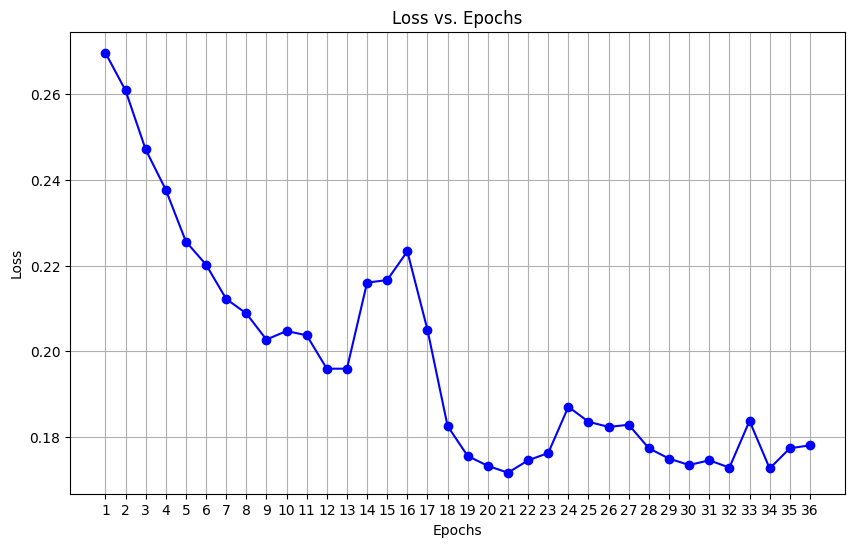

In [1]:
import matplotlib.pyplot as plt

# Loss values from your training logs
loss_values = [
    0.2697, 0.2609, 0.2471, 0.2377, 0.2256,
    0.2202, 0.2122, 0.2088, 0.2027, 0.2047,
    0.2037, 0.1959, 0.1959, 0.2160, 0.2166,
    0.2233, 0.2050, 0.1825, 0.1755, 0.1732,
    0.1716, 0.1745, 0.1762, 0.1870, 0.1835,
    0.1823, 0.1828, 0.1773, 0.1749, 0.1734,
    0.1745, 0.1728, 0.1837, 0.1726, 0.1773,
    0.1780
]

# Number of epochs
epochs = list(range(1, len(loss_values) + 1))

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

3D segmentation model by evaluating Dice loss, Dice score, and F1-score metrics, determines the optimal threshold for predictions, and visualizes the confusion matrix with class-wise metrics.

/tmp/ipykernel_30/4262294119.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path))


Loaded pre-trained model
Validation Loss: 0.0925, Dice Score: 0.8149
Best Threshold: 0.95, Best F1-Score: 0.5900
Confusion Matrix:


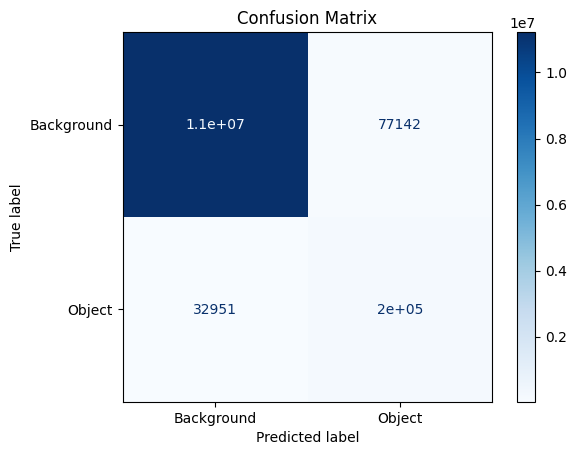

Class: Background, Precision: 0.9969, Recall: 0.9932, F1-Score: 0.9951
Class: Object, Precision: 0.7068, Recall: 0.8573, F1-Score: 0.7748


In [8]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_recall_fscore_support
)

class DiceCELoss(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(DiceCELoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets):
        """Compute Dice score and Cross Entropy Loss."""
        dice = custom_dice_score(inputs, targets)
        ce_loss = F.cross_entropy(inputs, targets)
        return self.alpha * (1 - dice) + (1 - self.alpha) * ce_loss

def custom_dice_score(pred, target, smooth=1e-6):
    """Calculate the Dice score."""
    pred = (pred > 0.5).float()  # Threshold to get binary predictions (as float)
    target = target.float()  # Ensure target is also float
    intersection = (pred * target).sum()  # Element-wise multiplication and sum
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def plot_confusion_matrix(preds, targets, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(targets.flatten(), preds.flatten(), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def calculate_class_metrics(preds, targets):
    """Calculate precision, recall, and F1-score for each class."""
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets.flatten(), preds.flatten(), average=None, zero_division=0
    )
    return precision, recall, f1

def validate(model, val_loader, device, thresholds=np.arange(0.0, 1.0, 0.05)):
    """Validate the model and print key metrics."""
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    criterion = DiceCELoss(alpha=0.5)  # Define the same loss function used in training
    total_dice_score = 0.0
    num_batches = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_batch in val_loader:  # Iterate through the validation data
            val_inputs = val_batch["vol"].to(device)
            val_labels = val_batch["seg"].to(device)

            # Forward pass
            val_outputs = model(val_inputs)

            # Compute validation loss
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            # Calculate Dice score using the custom function
            dice_score = custom_dice_score(val_outputs.reshape(-1), val_labels.reshape(-1))
            total_dice_score += dice_score.item()
            num_batches += 1

            # Store raw outputs for thresholding
            preds = val_outputs.cpu().numpy()  # Store raw model outputs
            targets = val_labels.cpu().numpy()  # Get targets in numpy format
            all_preds.append(preds)
            all_targets.append(targets)

    # Calculate average validation loss and Dice score
    avg_val_loss = total_val_loss / num_batches
    avg_dice_score = total_dice_score / num_batches
    print(f"Validation Loss: {avg_val_loss:.4f}, Dice Score: {avg_dice_score:.4f}")

    # Convert lists to numpy arrays
    all_preds = np.concatenate(all_preds)  # Raw predictions
    all_targets = np.concatenate(all_targets).astype(int)  # Ensure targets are binary

    # Initialize metrics
    best_f1 = 0
    best_threshold = 0

    # Experiment with different thresholds
    for threshold in thresholds:
        # Binarize predictions based on current threshold
        binary_preds = (all_preds > threshold).astype(int)
        
        # Calculate precision, recall, and F1-score
        precision, recall, f1 = calculate_class_metrics(binary_preds, all_targets)

        # Update best threshold based on F1-score
        if f1.mean() > best_f1:  # Use mean F1 for multiclass
            best_f1 = f1.mean()
            best_threshold = threshold

    print(f"Best Threshold: {best_threshold:.2f}, Best F1-Score: {best_f1:.4f}")

    # Final prediction using the best threshold
    final_preds = (all_preds > best_threshold).astype(int)

    # Print and plot the confusion matrix with final predictions
    print("Confusion Matrix:")
    plot_confusion_matrix(final_preds, all_targets, classes=["Background", "Object"])  # Explicitly pass class labels

    # Calculate and print class-wise precision, recall, and F1 scores
    precision, recall, f1 = calculate_class_metrics(final_preds, all_targets)
    for i, class_name in enumerate(["Background", "Object"]):
        print(f"Class: {class_name}, Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# Call the validation function
if __name__ == "__main__":
    in_channels = 1  # For grayscale images
    patch_size = 4   # Define your patch size
    embed_dim = 32   # Reduced embedding dimension
    num_classes = 1  # Output classes (for single-channel output)
    model = ConvNetWithAttention(in_channels, patch_size, embed_dim, num_classes)
    pretrained_model_path = '/kaggle/input/model/pytorch/v1/2/model (1).pth'
    
    # Load pre-trained weights
    if os.path.exists(pretrained_model_path):
        model.load_state_dict(torch.load(pretrained_model_path))
        print("Loaded pre-trained model")
    else:
        print("Pre-trained model not found, initializing a new model")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU

    # Assume data_in is your validation DataLoader
    validate(model, data_in, device)


In [10]:
torch.save(model.state_dict(), "model.pth")  # Save the state_dict of the model

Pre-trained segmentation model, processes a selected MRI scan, generates segmentation masks, and visualizes the input image, predicted output, and ground truth for a specific slice.

/tmp/ipykernel_30/1277668822.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path, map_location=torch.device('cpu')))


Loaded pre-trained model onto CPU
Loaded pre-trained model
Input Image Min: 0.0, Max: 1.0
Output Image Min: 0.0, Max: 1.0
Output Probs Min: 2.2964722745655308e-07, Max: 1.0


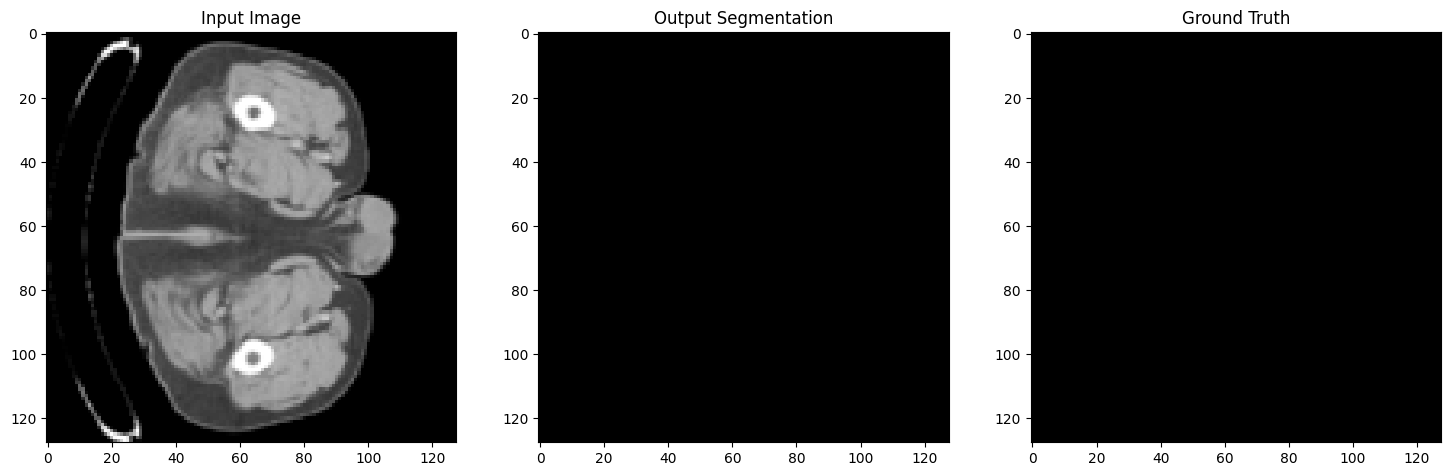

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_image(image):
    """Normalize an image tensor to the range [0, 1]."""
    image_min = image.min()
    image_max = image.max()
    if image_max > image_min:
        return (image - image_min) / (image_max - image_min)
    else:
        return np.zeros_like(image)  # Return zero array if range is zero

def visualize_output(input_tensor, output_tensor, ground_truth_tensor=None, slice_idx=None):
    input_image = input_tensor.squeeze().cpu().numpy()
    output_image = output_tensor.squeeze().detach().cpu().numpy()
    ground_truth_image = ground_truth_tensor.squeeze().cpu().numpy() if ground_truth_tensor is not None else None

    # Determine the slice index to display
    if slice_idx is None:
        slice_idx = input_image.shape[2] // 2  # Default to middle slice if not provided

    # Normalize images for better visualization
    input_image = normalize_image(input_image)
    output_image = normalize_image(output_image)
    if ground_truth_image is not None:
        ground_truth_image = normalize_image(ground_truth_image)

    fig, axes = plt.subplots(1, 3 if ground_truth_image is not None else 2, figsize=(18, 6))
    axes[0].imshow(input_image[..., slice_idx], cmap='gray')  # Specified slice
    axes[0].set_title('Input Image')
    
    axes[1].imshow(output_image[..., slice_idx], cmap='gray')  # Specified slice
    axes[1].set_title('Output Segmentation')

    if ground_truth_image is not None:
        axes[2].imshow(ground_truth_image[..., slice_idx], cmap='gray')  # Specified slice
        axes[2].set_title('Ground Truth')
    print(f'Input Image Min: {input_image.min()}, Max: {input_image.max()}')
    print(f'Output Image Min: {output_image.min()}, Max: {output_image.max()}')
    print(f'Output Probs Min: {output_probs.min().item()}, Max: {output_probs.max().item()}')


    plt.show()
in_channels = 1  # For grayscale images
patch_size = 4   # Define your patch size
embed_dim = 32   # Reduced embedding dimension
num_classes = 1  # Output classes (for single-channel output)
model = ConvNetWithAttention(in_channels, patch_size, embed_dim, num_classes)
pretrained_model_path = '/kaggle/input/model/pytorch/v1/1/model-2.pth'

# Load pre-trained weights with map_location set to 'cpu'
if os.path.exists(pretrained_model_path):
    model.load_state_dict(torch.load(pretrained_model_path, map_location=torch.device('cpu')))
    print("Loaded pre-trained model onto CPU")
else:
    print("Pre-trained model not found, initializing a new model")

# Define the index of the MRI scan you want to visualize
mri_scan_index = 10# Change this to the desired MRI scan index
slice_index = 1 # Change this to the desired slice index
device='cpu'
# Get a batch of images and labels for the specific index
batch = data_in.dataset[mri_scan_index]  # Fetch the data sample from the dataset
inputs = batch['vol'].unsqueeze(0).to(device)  # Add batch dimension and move to device
labels = batch['seg'].unsqueeze(0).to(device)  # Add batch dimension and move to device
in_channels = 1  # For grayscale images
patch_size = 4   # Define your patch size
embed_dim = 32   # Reduced embedding dimension
num_classes = 1  # Output classes (for single-channel output)
model = ConvNetWithAttention(in_channels, patch_size, embed_dim, num_classes)
pretrained_model_path = '/kaggle/input/model/pytorch/v1/2/model (1).pth'

# Load pre-trained weights
if os.path.exists(pretrained_model_path):
    model.load_state_dict(torch.load(pretrained_model_path))
    print("Loaded pre-trained model")
else:
    print("Pre-trained model not found, initializing a new model")

device = "cpu"
model.to(device)  # Move model to GPU


# Run the model on the selected MRI scan
outputs = model(inputs)
output_probs = torch.sigmoid(outputs)
output_masks = (output_probs > 0.5).float()

# Visualize the selected MRI scan along with ground truth
visualize_output(inputs[0], output_masks[0], ground_truth_tensor=labels[0], slice_idx=slice_index)
